<h2>Importowanie bibliotek</h2>


In [13]:

import matplotlib.pyplot as plot
from skimage import io, filters, color, morphology
import numpy as np
from scipy import ndimage as ndi
from operator import itemgetter
from numpy.linalg import norm
import math
from scipy.spatial import distance

<h2>Wczytywanie obrazka</h2>

8


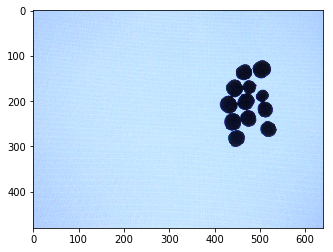

In [14]:
import cv2
import matplotlib.pyplot as plt
import skimage


s = input()
path =  './'

image = io.imread(path +s + '.jpg')

plt.imshow(image)

In [15]:
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(10,10)):
    
    import matplotlib.pyplot as plt
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

<h2>zamiana obrazu kolorowego na odcienie szarości</h2>

(480, 640, 3) uint8
(480, 640) uint8


C:\Users\Pawel\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


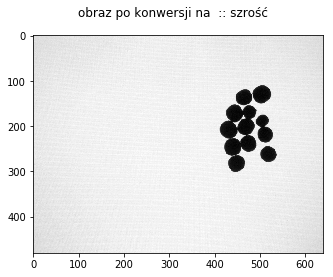

In [16]:
import numpy as np


image = io.imread(path + s + '.jpg')
print(image.shape, image.dtype)
#image = rgb2gray(image)
image = color.rgb2gray(image)
image = skimage.img_as_ubyte(image)
print(image.shape, image.dtype)

plt.imshow(image, cmap="gray")
plt.axis('on')
plt.suptitle('obraz po konwersji na  :: szrość')
plt.show()

pic = image


<h2>Binaryzacja</h2>

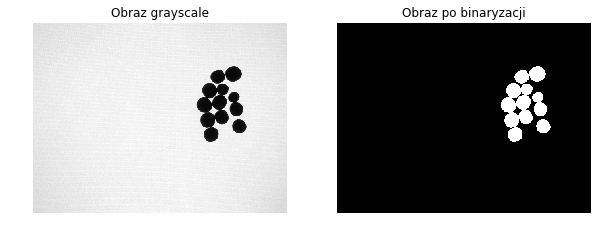

In [17]:
from skimage import data
import cv2


im = pic

th = 110
th, bim = cv2.threshold(im, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)

show2imgs(im, bim, title1='Obraz grayscale', title2='Obraz po binaryzacji', size=(10,10))
pixel = bim

<h2>Rozdzielanie elementów</h2>

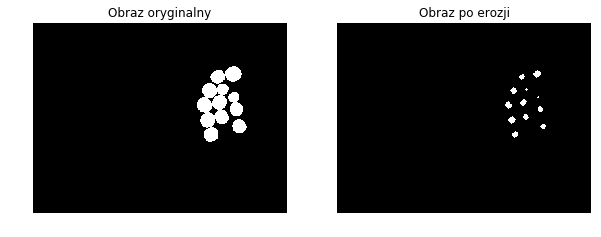

In [18]:
import cv2
import numpy as np

kernel = np.ones((3,3),np.uint8)

#dilateBin = cv2.dilate(bim, kernel=kernel, iterations=4)
erodeBin = cv2.erode(bim, kernel=kernel, iterations=8)



show2imgs(bim, erodeBin, title1='Obraz oryginalny', title2='Obraz po erozji', size=(10,10))
#show2imgs(erodeBin, dilateBin, title1='Obraz po erozji', title2='Obraz zbinaryzowany  po dylatacji', size=(10,10))

copy = erodeBin

<h2>Zliczanie Obiektów</h2>

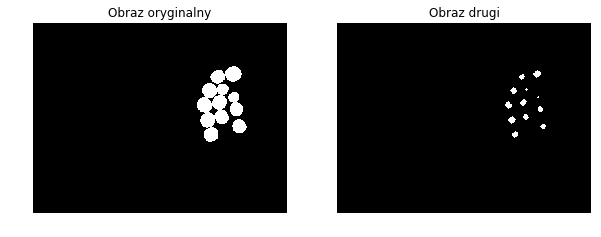

ilość obiektów =  12


In [19]:
ilosc = 0

for  x  in range(copy.shape[0]):
    for y in range(copy.shape[1]):
        if copy[x,y]==255:
           # print("test")
            ilosc+=1
            cv2.floodFill(copy, None, seedPoint=(y, x), newVal=170)

show2imgs(pixel, copy, title1='Obraz oryginalny', size=(10,10))
print("ilość obiektów = ",ilosc)


<h2>Liczenie ilości pixeli i procentowy obszar zajmowany orzez obiekty</h2>

In [20]:
piksele_elementow = 0
for x in range(pixel.shape[0]):
    for y in range(pixel.shape[1]):
        if pixel[x,y]!=0:
            piksele_elementow +=1
        
print('ilość pixeli elementów = ',piksele_elementow)

ilość pixeli elementów =  12004


In [21]:


b= pixel.shape[1]*pixel.shape[0]
print("ilossc pixeli na obrazku = ",b)

print('procent obszaru zdjęcia jaki stanowią analizowane obiekty = ',(piksele_elementow/b)*100,'%')

ilossc pixeli na obrazku =  307200
procent obszaru zdjęcia jaki stanowią analizowane obiekty =  3.9075520833333335 %


<h2>Wynaczanie środka ciężkości</h2>

[(130, 504), (136, 465), (172, 444), (169, 477), (188, 505), (201, 469), (208, 431), (218, 511), (238, 475), (246, 440), (261, 519), (282, 448)]


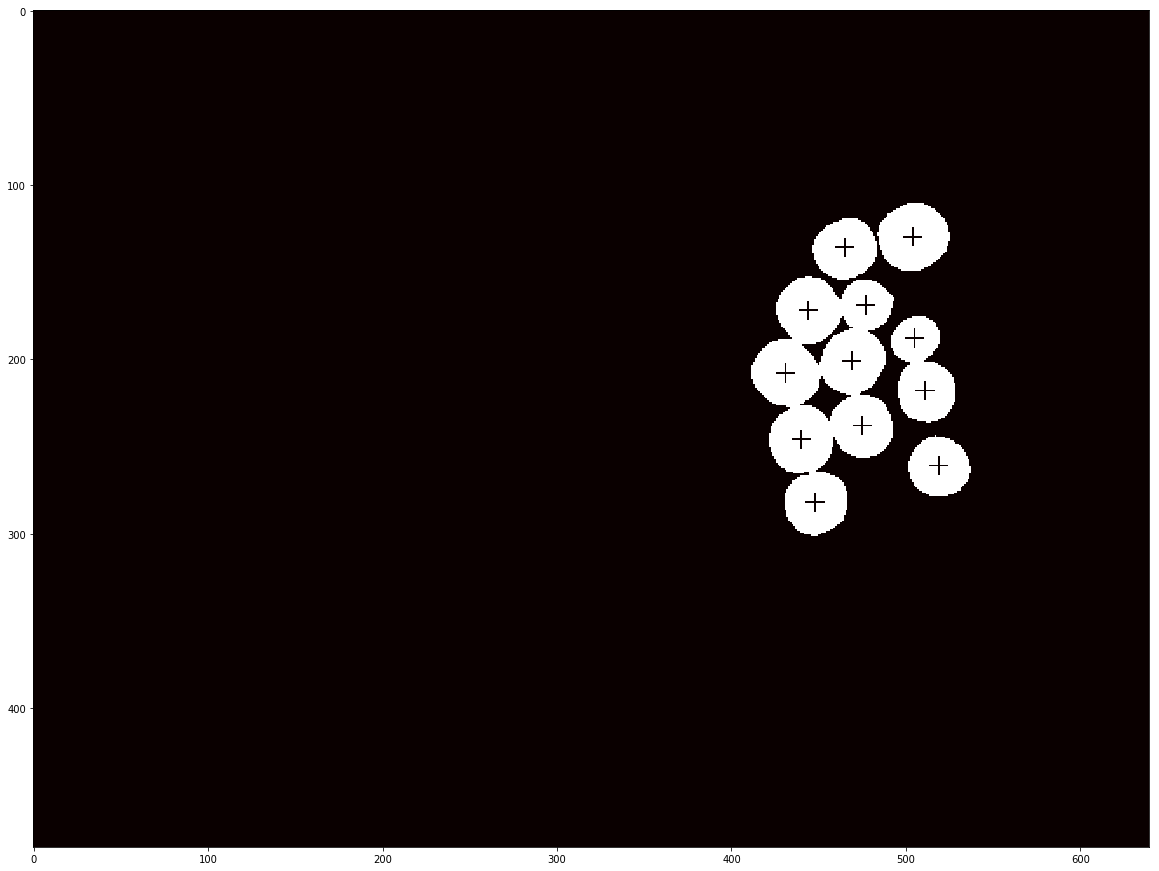

In [22]:
from scipy import ndimage as ndi
label_objects, nb_labels = ndi.label(erodeBin)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0



def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

cogs = []
for i in range(nb_labels):
    cogs.append(cog(label_objects, i+1))

print(cogs)

def drawMarkers(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-5, y+6):
            image[j,x] = 0
        for i in range(x-5, x+6):
            image[y,i] = 0
            
    return image


lo = drawMarkers(bim, cogs)
plt.figure(figsize=(20,20))
plt.imshow(lo,cmap='hot')
plt.show()

<h2>Wyznaczanie współczynników Fereta i Blaira-Blissa </h2>

In [23]:
def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points


from scipy.spatial import distance

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]

def computeBB(points):
    
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))


def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)   

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = computeBB(pts)
    feret = computeFeret(pts)
    
    print('Liczba punktow: ',len(pts),'\nSrodek ciezkosci: ', cog2(pts),'\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n')

Liczba punktow:  251 
Srodek ciezkosci:  [130.10756972111554, 504.3625498007968] 
Blair-Bliss:  0.9861711038621757 
Feret:  0.9 

Liczba punktow:  144 
Srodek ciezkosci:  [136.97222222222223, 465.50694444444446] 
Blair-Bliss:  0.9792071430658035 
Feret:  0.9333333333333333 

Liczba punktow:  185 
Srodek ciezkosci:  [172.05945945945945, 444.4972972972973] 
Blair-Bliss:  0.9790580830572977 
Feret:  1.2666666666666666 

Liczba punktow:  48 
Srodek ciezkosci:  [169.25, 477.0208333333333] 
Blair-Bliss:  0.9875734657049617 
Feret:  1.0 

Liczba punktow:  16 
Srodek ciezkosci:  [188.625, 505.625] 
Blair-Bliss:  0.827506789243521 
Feret:  1.0 

Liczba punktow:  184 
Srodek ciezkosci:  [201.41304347826087, 469.44565217391306] 
Blair-Bliss:  0.9800402983261418 
Feret:  1.0 

Liczba punktow:  212 
Srodek ciezkosci:  [208.16981132075472, 431.35849056603774] 
Blair-Bliss:  0.9749964170587073 
Feret:  1.0555555555555556 

Liczba punktow:  139 
Srodek ciezkosci:  [218.6043165467626, 511.7122302158273

<h2>Podsumowanie - sprawdzenie dla pozostałych danych wejściowych</h2>

In [24]:
tab = [9,9,8,7,12,7,6,12,7,9,9,9,9,9,9,7] #wyniki;
for i in range(len(tab)):
    path =  './'
    image = io.imread(path +str(i+1)+ '.jpg')
  
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    th = 110
    th, bim = cv2.threshold(image, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3),np.uint8)
    erodeBin = cv2.erode(bim, kernel=kernel, iterations=8)
    copy = erodeBin
    ilosc = 0

    for  x  in range(copy.shape[0]):
        for y in range(copy.shape[1]):
            if copy[x,y]==255:
           # print("test")
                ilosc+=1
                cv2.floodFill(copy, None, seedPoint=(y, x), newVal=170)

   
    print("ilość obiektów = ",ilosc)
    dziala_or_not= True
    if(ilosc!=tab[i]):
        dziala_or_not=False
    
    zmienna ='działa'
    if(dziala_or_not==False):
        zmienna='nie dziala'
    print("Zdjęcie numer: ",i+1," Posiada: ",tab[i],"a według proramu ma: ",ilosc," Tak wiec program ",zmienna)
   

ilość obiektów =  9
Zdjęcie numer:  1  Posiada:  9 a według proramu ma:  9  Tak wiec program  działa
ilość obiektów =  9
Zdjęcie numer:  2  Posiada:  9 a według proramu ma:  9  Tak wiec program  działa
ilość obiektów =  8
Zdjęcie numer:  3  Posiada:  8 a według proramu ma:  8  Tak wiec program  działa
ilość obiektów =  7
Zdjęcie numer:  4  Posiada:  7 a według proramu ma:  7  Tak wiec program  działa
ilość obiektów =  12
Zdjęcie numer:  5  Posiada:  12 a według proramu ma:  12  Tak wiec program  działa
ilość obiektów =  7
Zdjęcie numer:  6  Posiada:  7 a według proramu ma:  7  Tak wiec program  działa
ilość obiektów =  6
Zdjęcie numer:  7  Posiada:  6 a według proramu ma:  6  Tak wiec program  działa
ilość obiektów =  12
Zdjęcie numer:  8  Posiada:  12 a według proramu ma:  12  Tak wiec program  działa
ilość obiektów =  7
Zdjęcie numer:  9  Posiada:  7 a według proramu ma:  7  Tak wiec program  działa
ilość obiektów =  9
Zdjęcie numer:  10  Posiada:  9 a według proramu ma:  9  Tak wiec